# Vehicle Fuel Effiencey Prediction

Predict the vehicle fuel efficiency using linear regression

Dataset source: <https://archive.ics.uci.edu/ml/datasets/auto+mpg>


Import the libraries

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


Load the dataset

In [89]:
df = pd.read_csv("dataset/auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


## Data Summarization and Visualization

Shows the summary of the data

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


We can see that all columns in our dataset is in numerical values, and there's some missing values in horsepower column

Check how many missing values in the dataset

In [91]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

There's 6 missing values in horsepower column, next we fill the missing values using the mean of that column

In [92]:
df = df.fillna(df['horsepower'].mean())

Generate descriptive statistics of the dataset

In [93]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.469388,38.199187,46.0,76.000,95.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [94]:
df['origin'] = df['origin'].map({1: 'USA', 2: 'europe', 3: 'japan'})

In [95]:
df = pd.get_dummies(df, columns=['origin'], prefix='', prefix_sep='')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,USA,europe,japan
0,18.0,8,307.0,130.0,3504,12.0,70,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,buick skylark 320,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,plymouth satellite,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,amc rebel sst,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,ford torino,1,0,0


In [96]:
df = df.drop(['car name'], axis=1)

In [97]:
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,europe,japan
mpg,1.000000,-0.775396,-0.804203,-0.771437,-0.831741,0.420289,0.579267,-0.568192,0.259022,0.442174
cylinders,-0.775396,1.000000,0.950721,0.838939,0.896017,-0.505419,-0.348746,0.604351,-0.352861,-0.396479
displacement,-0.804203,0.950721,1.000000,0.893646,0.932824,-0.543684,-0.370164,0.651407,-0.373886,-0.433505
horsepower,-0.771437,0.838939,0.893646,1.000000,0.860574,-0.684259,-0.411651,0.486083,-0.281258,-0.321325
weight,-0.831741,0.896017,0.932824,0.860574,1.000000,-0.417457,-0.306564,0.598398,-0.298843,-0.440817
acceleration,0.420289,-0.505419,-0.543684,-0.684259,-0.417457,1.000000,0.288137,-0.250806,0.204473,0.109144
model year,0.579267,-0.348746,-0.370164,-0.411651,-0.306564,0.288137,1.000000,-0.139883,-0.024489,0.193101
USA,-0.568192,0.604351,0.651407,0.486083,0.598398,-0.250806,-0.139883,1.000000,-0.597198,-0.643317
europe,0.259022,-0.352861,-0.373886,-0.281258,-0.298843,0.204473,-0.024489,-0.597198,1.000000,-0.229895
japan,0.442174,-0.396479,-0.433505,-0.321325,-0.440817,0.109144,0.193101,-0.643317,-0.229895,1.000000


Plot pairwise relationships in the dataset

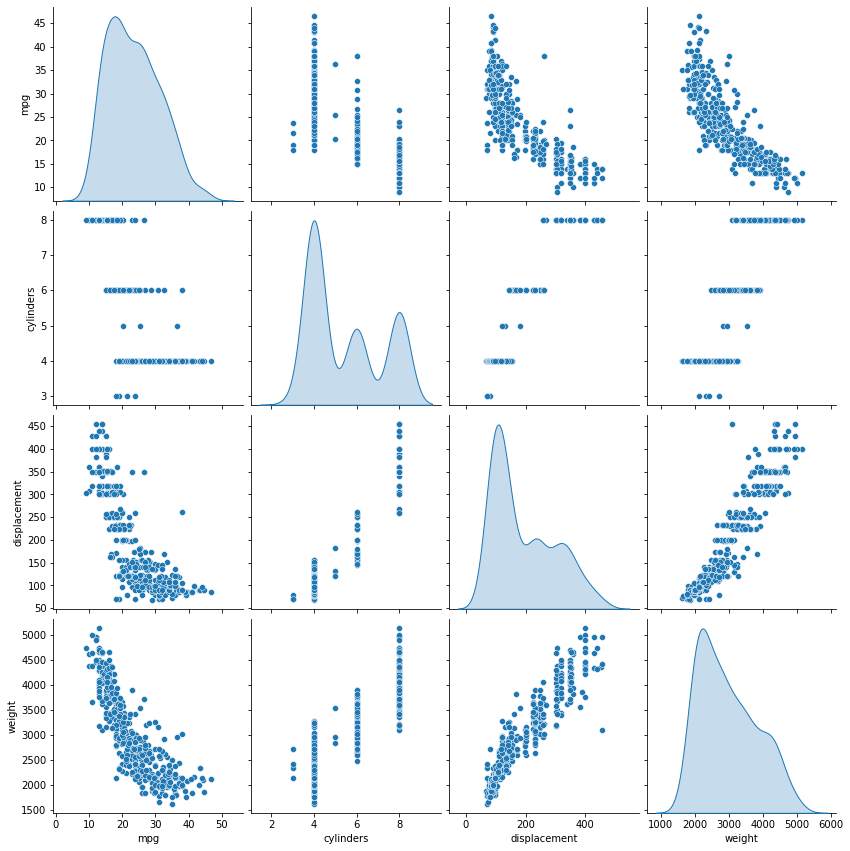

In [98]:
sns.pairplot(df[['mpg', 'cylinders', 'displacement', 'weight']], diag_kind='kde', height=3)

Split the target and features column

In [99]:
X = df.drop(['mpg'], axis=1)
y = pd.DataFrame(df['mpg'].copy())

Split the training and testing set, then print the shapes of each splitted data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(318, 9) (80, 9) (318, 1) (80, 1)


In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

Train a linear model using sklearn Linear Regression

In [102]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Shows the regressor intercept

In [103]:
print(regressor.intercept_)

[23.6081761]


In [104]:
X

,cylinders,displacement,horsepower,weight,acceleration,model year,USA,europe,japan
0,8,307.0,130.0,3504,12.0,70,1,0,0
1,8,350.0,165.0,3693,11.5,70,1,0,0
2,8,318.0,150.0,3436,11.0,70,1,0,0
3,8,304.0,150.0,3433,12.0,70,1,0,0
4,8,302.0,140.0,3449,10.5,70,1,0,0
...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790,15.6,82,1,0,0
394,4,97.0,52.0,2130,24.6,82,0,1,0
395,4,135.0,84.0,2295,11.6,82,1,0,0
396,4,120.0,79.0,2625,18.6,82,1,0,0


In [105]:
X.columns[0]

'cylinders'

Shows the feature importance

In [106]:
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance[0]):
	print(f'Feature {i} ({X.columns[i]})\nScore: {v:.3f}\n')

Feature 0 (cylinders)
Score: -0.275

Feature 1 (displacement)
Score: 2.014

Feature 2 (horsepower)
Score: -0.494

Feature 3 (weight)
Score: -5.936

Feature 4 (acceleration)
Score: 0.202

Feature 5 (model year)
Score: 2.977

Feature 6 (USA)
Score: -0.768

Feature 7 (europe)
Score: 0.518

Feature 8 (japan)
Score: 0.435



Plot the feature importance

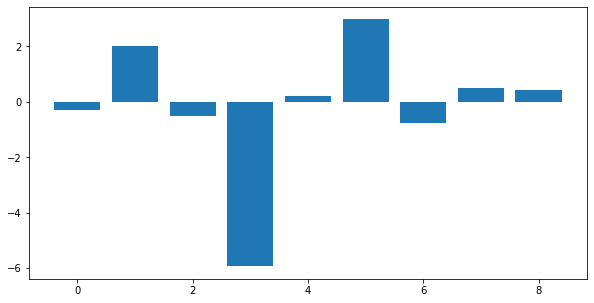

In [107]:
plt.figure(figsize=(10,5))
plt.bar([x for x in range(len(importance[0]))], importance[0])
plt.show()

In [108]:
regressor.coef_

array([[-0.27544311,  2.01366001, -0.49384575, -5.93612313,  0.20236728,
         2.9765687 , -0.76836861,  0.51769996,  0.43506917]])

In [109]:
training_r2 = regressor.score(X_train, y_train)
print(f'Training R-Squared: {training_r2:.3f}')

Training R-Squared: 0.819


In [110]:
testing_r2 = regressor.score(X_test, y_test)
print(f'Testing R-Squared: {testing_r2:.3f}')

Testing R-Squared: 0.850


In [111]:
normalizer = tf.keras.layers.Normalization(axis=1)

In [112]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [113]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [114]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

In [115]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

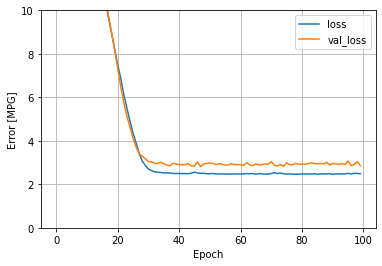

In [116]:
plot_loss(history)

In [117]:
tf_training_predict = model.predict(X_train)

10/10 [==============================] - 0s 830us/step


In [118]:
r2 = r2_score(y_train, tf_training_predict)
r2

0.8026941641098153